**Import des données**

In [35]:
# 📦 Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_parquet('../data/parquet/full_2020.csv.parquet', engine='pyarrow')

**Optimisation**

In [36]:
# Liste des colonnes à supprimer (remplissage < 10%)
cols_to_drop_1 = [
    'ancien_code_commune', 'ancien_nom_commune', 'ancien_id_parcelle',
    'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez',
    'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez',
    'lot5_numero', 'lot5_surface_carrez'
]
# Liste des colonnes avec infos inutiles
cols_to_drop_2 = [
    'id_mutation', 'numero_disposition', 'adresse_numero', 'adresse_suffixe',
    'adresse_nom_voie', 'adresse_code_voie', 'nom_commune', 'id_parcelle',
    'numero_volume', 'code_nature_culture', 'nature_culture','code_nature_culture_speciale'
]
df.drop(columns=cols_to_drop_1, inplace=True)
# Vérification des colonnes restantes
print(f"Shape after dropping columns: {df.shape}")

def optimize_dataframe(df, parse_dates=None, category_thresh=0.05, verbose=True):
    """
    Optimise les types d'un DataFrame pour réduire l'utilisation mémoire :
    - convertit les objets en catégories si nombre de modalités faible
    - convertit les float64 en float32
    - convertit les int64 en int32
    - convertit les colonnes de dates

    Parameters:
    - df : DataFrame à optimiser
    - parse_dates : liste de colonnes à parser comme dates
    - category_thresh : seuil max de ratio modalité/nb lignes pour transformer en 'category'
    - verbose : affiche la mémoire gagnée

    Returns:
    - df optimisé
    """

    initial_memory = df.memory_usage(deep=True).sum() / 1024**2

    # Dates
    if parse_dates:
        for col in parse_dates:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Float → float32
    float_cols = df.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df[col] = df[col].astype('float32')

    # Int → int32
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        if df[col].isnull().any():
            df[col] = df[col].astype('Int32')
        else:
            df[col] = df[col].astype('int32')

    # Object → category si peu de modalités
    for col in df.select_dtypes(include='object').columns:
        if df[col].nunique(dropna=False) / len(df) <= category_thresh:
            df[col] = df[col].astype('category')

    final_memory = df.memory_usage(deep=True).sum() / 1024**2

    if verbose:
        print(f"💾 Mémoire utilisée : {initial_memory:.2f} Mo → {final_memory:.2f} Mo ({100 * (1 - final_memory/initial_memory):.1f}% gagné)")

    return df

# Application test sur ech_annonces_ventes_68.csv
optimized_df1 = optimize_dataframe(df, parse_dates=['date_mutation'], verbose=True)
optimized_df1.info()
optimized_df1.head()


Shape after dropping columns: (3522416, 27)
💾 Mémoire utilisée : 2855.43 Mo → 862.50 Mo (69.8% gagné)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522416 entries, 0 to 3522415
Data columns (total 27 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   id_mutation                   object        
 1   date_mutation                 datetime64[ns]
 2   numero_disposition            int32         
 3   nature_mutation               category      
 4   valeur_fonciere               float32       
 5   adresse_numero                float32       
 6   adresse_suffixe               category      
 7   adresse_nom_voie              object        
 8   adresse_code_voie             category      
 9   code_postal                   float32       
 10  code_commune                  category      
 11  nom_commune                   category      
 12  code_departement              category      
 13  id_parcelle                   

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,numero_volume,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2020-1,2020-01-07,1,Vente,8000.0,NaN,NaN,FORTUNAT,B063,1250.0,01072,Ceyzériat,01,01072000AK0216,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1061.0,5.323532,46.171940
1,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,TERRES DES CINQ SAULES,B124,1290.0,01203,Laiz,01,012030000B0004,NaN,0,NaN,NaN,NaN,NaN,BT,taillis simples,NaN,NaN,85.0,4.893454,46.251858
2,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,BOIS DU CHAMP RION,B006,1290.0,01203,Laiz,01,012030000B0173,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1115.0,4.900210,46.235275
3,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,EN COROBERT,B025,1290.0,01203,Laiz,01,012030000B0477,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1940.0,4.882112,46.246555
4,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,TERRES DES CINQ SAULES,B124,1290.0,01203,Laiz,01,012030000C0068,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1148.0,4.894481,46.251842


**Split**

In [37]:
# Le but est de voir si la commune est grande ou petite en fonction du nombre d'apparition dans le tableau
optimized_df1 = optimized_df1.dropna()

commune_freq = optimized_df1['nom_commune'].value_counts()
optimized_df1['commune_freq'] = optimized_df1['nom_commune'].map(commune_freq)


optimized_df1 = optimized_df1.drop(['adresse_numero', 'adresse_suffixe', 'adresse_nom_voie','adresse_code_voie', 'code_postal', 'nom_commune','numero_volume','nature_culture_speciale','code_nature_culture_speciale'], axis=1)
optimized_df1['coordonnees'] = list(zip(optimized_df1['latitude'], optimized_df1['longitude']))

colonnes_choisies = [
    'valeur_fonciere', 'surface_terrain', 'surface_reelle_bati',
    'type_local', 'code_type_local', 'nombre_pieces_principales',
    'commune_freq', 'nombre_lots'
]

dfRFR = optimized_df1[colonnes_choisies].copy()

# Définir X (features) et y (target)
X = dfRFR.drop(columns='valeur_fonciere')
y = dfRFR['valeur_fonciere']

# Découper en train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

**Pré processing**

In [26]:
# conversion de type
optimized_df1['code_type_local'] = optimized_df1['code_type_local'].fillna(0).astype(int)
optimized_df1['type_local'] = optimized_df1['type_local'].astype('string').fillna('Inconnu')
optimized_df1['nature_mutation'] = optimized_df1['nature_mutation'].astype('string')
optimized_df1['code_nature_culture'] = optimized_df1['code_nature_culture'].astype('string').fillna('0')
optimized_df1['nature_culture'] = optimized_df1['nature_culture'].astype('string').fillna('0')

KeyError: "['adresse_numero', 'adresse_suffixe', 'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'nom_commune', 'numero_volume', 'nature_culture_speciale', 'code_nature_culture_speciale'] not found in axis"

**One Hot Encoding**

In [25]:
# code_type_local
optimized_df1 = pd.get_dummies(optimized_df1, columns=['code_type_local'], prefix='code_type_local')

# type_local
categories_type = ['Inconnu', 'Maison', 'Appartement', 'Dépendance', 'Local industriel. commercial ou assimilé']
optimized_df1['type_local'] = pd.Categorical(optimized_df1['type_local'], categories=categories_type)
optimized_df1 = pd.get_dummies(optimized_df1, columns=['type_local'], prefix='type_local')

# nature_mutation
categories_mut = ['Vente', 'Vente terrain à bâtir', 'Echange', "Vente en l'état futur d'achèvement", 'Adjudication','Expropriation']
optimized_df1['nature_mutation'] = pd.Categorical(optimized_df1['nature_mutation'], categories=categories_mut)
optimized_df1 = pd.get_dummies(optimized_df1, columns=['nature_mutation'], prefix='nature_mutation')

# code_nature_culture

categories_code_nature = [ '0','T', 'BT', 'AB', 'S', 'J', 'P', 'BS', 'AG', 'L', 'VI', 'VE', 'BP', 'CH', 'BR', 'E', 'BF', 'CA', 'B', 'PA', 'BM', 'BO', 'PP', 'PC', 'TP', 'LB', 'PH', 'PE']
optimized_df1['code_nature_culture'] = pd.Categorical(optimized_df1['code_nature_culture'], categories=categories_code_nature)
optimized_df1 = pd.get_dummies(optimized_df1, columns=['code_nature_culture'], prefix='code_nature_culture')

# nature_culture
categories_nature = [ '0','terres', 'taillis simples', 'terrains a bâtir', 'sols', 'jardins', 'prés', 'taillis sous futaie', "terrains d'agrément", 'landes', 'vignes', 'vergers', 'peupleraies', 'chemin de fer', 'futaies résineuses', 'eaux', 'futaies feuillues', 'carrières', 'bois', 'pâtures', 'futaies mixtes', 'oseraies', 'prés plantes', 'pacages', 'terres plantées', 'landes boisées', 'herbages', "prés d'embouche"]
optimized_df1['nature_culture'] = pd.Categorical(optimized_df1['nature_culture'], categories=categories_nature)
optimized_df1 = pd.get_dummies(optimized_df1, columns=['nature_culture'], prefix='nature_culture')

KeyError: "None of [Index(['code_type_local'], dtype='object')] are in the [columns]"

**Post DropNa**

In [ ]:
# Corrélation de Spearman
spearman_corr = optimized_df1.corr(method='spearman', numeric_only=True)

# Extraire les corrélations avec 'valeur_fonciere' uniquement
valeur_corr_spearman = spearman_corr['valeur_fonciere'].drop('valeur_fonciere')

# Trier par valeur absolue (décroissant)
valeur_corr_spearman_sorted = valeur_corr_spearman.reindex(valeur_corr_spearman.abs().sort_values(ascending=False).index)

# Affichage
print(valeur_corr_spearman_sorted)

commune_freq             0.352145
surface_terrain          0.261448
surface_reelle_bati      0.221233
code_type_local_1       -0.216992
type_local_Maison       -0.216992
                           ...   
code_type_local_3             NaN
type_local_Inconnu            NaN
type_local_Dépendance         NaN
code_nature_culture_0         NaN
nature_culture_0              NaN
Name: valeur_fonciere, Length: 80, dtype: float64


**Premier Test RandomForestRegressor**

RMSE ≈ 2 470 772 €

R² ≈ 0.935

In [ ]:
print(X_train.shape, X_test.shape)

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)  # RMSE ici
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("R² :", r2)


importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,5))
plt.title("Importance des variables")
plt.show()

dfRFR.info()

(2817932, 7) (704484, 7)


ValueError: could not convert string to float: 'Dépendance'

**Fonction logarithmique**

RMSE : 3115740.937183387

R² : 0.8963601575459054

(666956, 7) (166740, 7)
RMSE : 3115740.937183387
R² : 0.8963601575459054


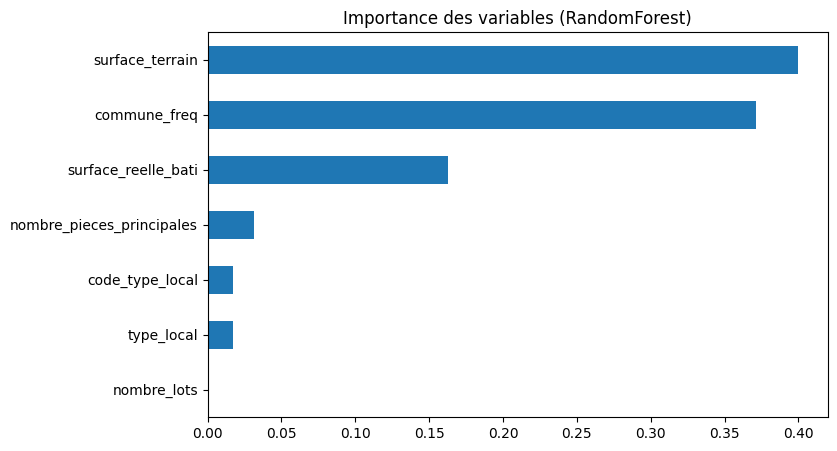

In [ ]:
# Colonnes choisies
colonnes_choisies = [
    'valeur_fonciere', 'surface_terrain', 'surface_reelle_bati',
    'type_local', 'code_type_local', 'nombre_pieces_principales',
    'commune_freq', 'nombre_lots'
]
dfRFRLog = optimized_df1[colonnes_choisies].copy()

# Définir X (features) et y (target)
X = dfRFRLog.drop(columns='valeur_fonciere')
y = dfRFRLog['valeur_fonciere']

# Transformation log de la cible
y_log = np.log1p(y)  # log1p gère les y=0 éventuels

# Découper en train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

# Modèle RandomForest
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Prédictions dans l'espace log
y_pred_log = model.predict(X_test)

# Retour à l'échelle des prix réels
y_pred = np.expm1(y_pred_log)     # inverse de log1p
y_test_real = np.expm1(y_test)    # idem pour la vraie valeur

# Évaluation
rmse = root_mean_squared_error(y_test_real, y_pred)
r2 = r2_score(y_test_real, y_pred)

print("RMSE :", rmse)
print("R² :", r2)

# Importance des variables
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,5))
plt.title("Importance des variables (RandomForest)")
plt.show()

**Suppression des valeurs aberrantes**

RMSE : 92186.59412765941

R² : 0.366582826222593

(600081, 7) (150021, 7)
RMSE : 103845.17217765008
R² : 0.3934249456937223


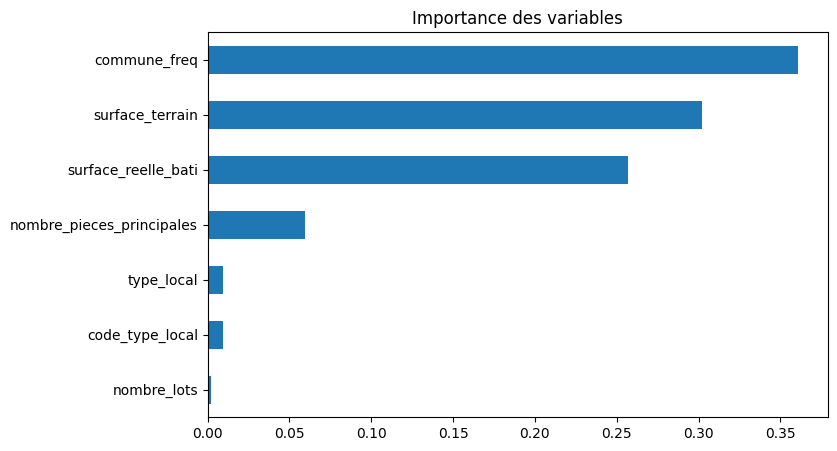

In [ ]:
# Calcul des quartiles pour la colonne valeur_fonciere
Q1 = optimized_df1['valeur_fonciere'].quantile(0.25)
Q3 = optimized_df1['valeur_fonciere'].quantile(0.75)
IQR = Q3 - Q1

# Suppression des valeurs aberrantes uniquement selon valeur_fonciere
optimized_df1 = optimized_df1[
    (optimized_df1['valeur_fonciere'] >= Q1 - 1.5 * IQR) &
    (optimized_df1['valeur_fonciere'] <= Q3 + 1.5 * IQR)
]

dfRFR = optimized_df1[colonnes_choisies].copy()


# Définir X (features) et y (target)
X = dfRFR.drop(columns='valeur_fonciere')
y = dfRFR['valeur_fonciere']

# Découper en train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)  # RMSE ici
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("R² :", r2)


importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,5))
plt.title("Importance des variables")
plt.show()


**Test LightGBM**

RMSE : 110068.43252065268

R² : 0.3185445167670684

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 800
[LightGBM] [Info] Number of data points in the train set: 600081, number of used features: 7
[LightGBM] [Info] Start training from score 11.964992
RMSE : 103845.17225817383
R² : 0.39342494116017046


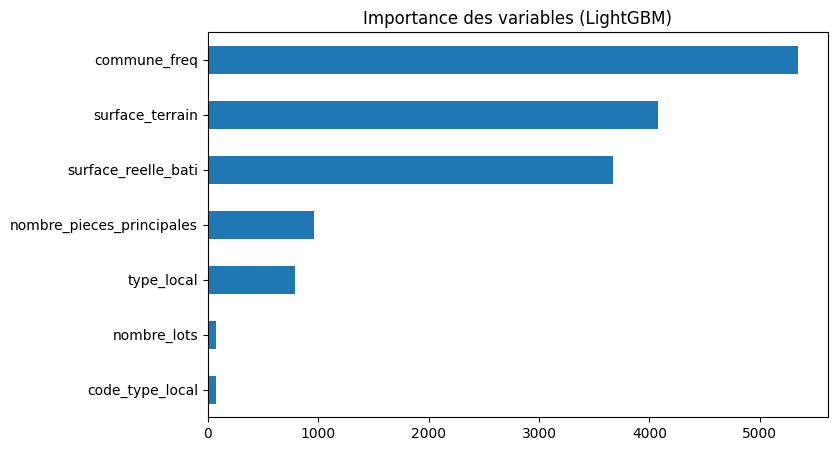

In [ ]:


colonnes_choisies = [
    'valeur_fonciere', 'surface_terrain', 'surface_reelle_bati',
    'type_local', 'code_type_local', 'nombre_pieces_principales',
    'commune_freq', 'nombre_lots'
]
dfRFR = optimized_df1[colonnes_choisies].copy()

X = dfRFR.drop(columns='valeur_fonciere')
y = dfRFR['valeur_fonciere']


y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf_log = rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_rf_log)
y_test_real = np.expm1(y_test)


lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)

y_pred_lgbm_log = lgbm.predict(X_test)
y_pred_lgbm = np.expm1(y_pred_lgbm_log)


rmse = root_mean_squared_error(y_test_real, y_pred)
r2 = r2_score(y_test_real, y_pred)

print("RMSE :", rmse)
print("R² :", r2)


importances = pd.Series(lgbm.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,5))
plt.title("Importance des variables (LightGBM)")
plt.show()

**Tentative avec NN Tensorflow / Kera**

RMSE : 9509432.0

R² : 0.03458684682846069

In [ ]:
colonnes_choisies = [
    'valeur_fonciere', 'surface_terrain', 'surface_reelle_bati',
    'type_local', 'code_type_local', 'nombre_pieces_principales',
    'commune_freq', 'nombre_lots'
]
dfRFR = optimized_df1[colonnes_choisies].copy()


X = dfRFR.drop(columns=["valeur_fonciere"])
y = dfRFR["valeur_fonciere"]

# Normalisation (les NN aiment ça)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Découpage train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Modèle de réseau de neurones
model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)  # sortie = valeur fonciere
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Entraînement
history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    epochs=50, batch_size=256)



y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)  # RMSE ici
r2 = r2_score(y_test, y_pred)

mse, mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Erreur quadratique moyenne (MSE): {mse:.2f}")
print(f"Erreur absolue moyenne (MAE): {mae:.2f}")

print("RMSE :", rmse)
print("R² :", r2)

Epoch 1/50


c:\Users\shipu\Documents\GitHub\compagnon-immobilier\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2085/2085 ━━━━━━━━━━━━━━━━━━━━ 2s 652us/step - loss: 91570028150784.0000 - mae: 1358562.2500 - val_loss: 90802512461824.0000 - val_mae: 1353290.8750
Epoch 2/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - loss: 90394960330752.0000 - mae: 1344766.0000 - val_loss: 89008348594176.0000 - val_mae: 1413869.7500
Epoch 3/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - loss: 88643855187968.0000 - mae: 1480864.8750 - val_loss: 87504069853184.0000 - val_mae: 1592465.1250
Epoch 4/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - loss: 87670063628288.0000 - mae: 1642551.0000 - val_loss: 86915072131072.0000 - val_mae: 1720321.2500
Epoch 5/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - loss: 87293004087296.0000 - mae: 1733238.5000 - val_loss: 86643365117952.0000 - val_mae: 1786265.8750
Epoch 6/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - loss: 87091685883904.0000 - mae: 1784660.1250 - val_loss: 86470845005824.0000 - val_mae: 1823226.6250
Epoch 7/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/